In [56]:
import cv2
from ultralytics import YOLO
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
img_path = '../images/hornet.jpg'

In [3]:
img_cv = cv2.imread(img_path)

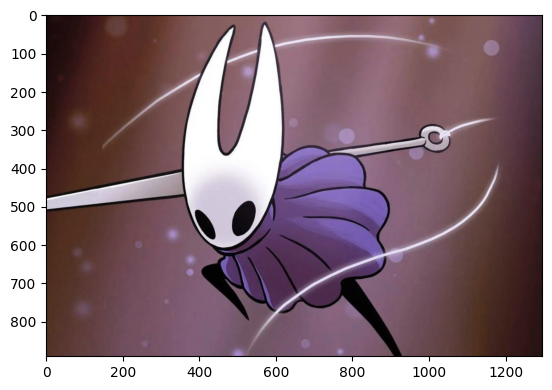

In [4]:
plt.imshow(img_cv)
plt.show()

In [5]:
model = YOLO('yolov8n-seg.pt')

In [6]:
result = model(img_cv)


0: 448x640 1 surfboard, 63.5ms
Speed: 4.8ms preprocess, 63.5ms inference, 28.4ms postprocess per image at shape (1, 3, 448, 640)


In [7]:
type(result[0])

ultralytics.engine.results.Results

In [8]:
len(result)

1

In [9]:
masks = result[0].masks

In [10]:
mask = masks.data[0].cpu().numpy()

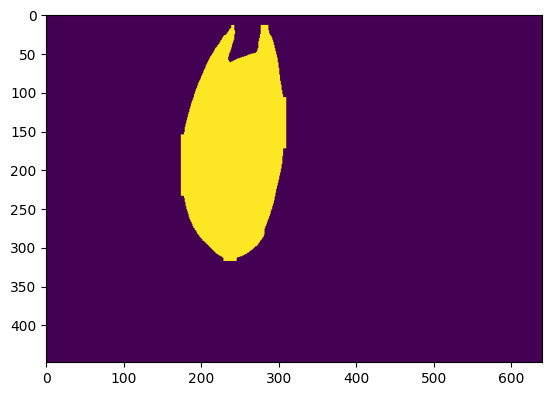

In [11]:
plt.imshow(mask)
plt.show()

In [12]:
lab = cv2.cvtColor(img_cv, cv2.COLOR_BGR2LAB)

In [13]:
l, a, b = cv2.split(lab)

In [14]:
clahe = cv2.createCLAHE(2.5, (8,8))

In [15]:
l2 = clahe.apply(l)

In [16]:
merged = cv2.merge((l2,a,b))

In [17]:
enhanced = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

In [18]:
img_cv_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)

In [19]:
enhanced_bgr = cv2.cvtColor(enhanced, cv2.COLOR_RGB2BGR)

In [20]:
resutl = model(enhanced_bgr)


0: 448x640 (no detections), 5.5ms
Speed: 3.8ms preprocess, 5.5ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


In [21]:
masks = result[0].masks

In [22]:
mask = masks.data[0].cpu().numpy()

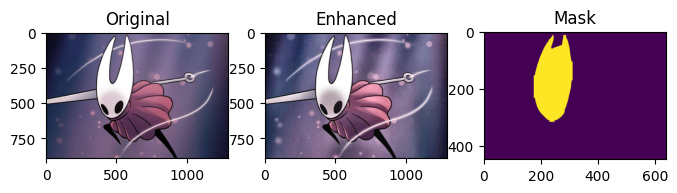

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(8,4))
axes[0].imshow(img_cv_rgb)
axes[0].set_title('Original')

axes[1].imshow(enhanced)
axes[1].set_title('Enhanced')

axes[2].imshow(mask)
axes[2].set_title('Mask')

plt.show()

In [24]:
img_gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)

In [274]:
pad = 2
padded_gray = cv2.copyMakeBorder(
    img_gray,
    pad, pad, pad, pad,
    cv2.BORDER_CONSTANT,
    value=128
)

In [275]:
edges = cv2.Canny(
    padded_gray, 50, 150
)

num_iter = 10
img_gray_dil = cv2.dilate(img_gray, None, iterations= num_iter)
img_gray_ero = cv2.erode(img_gray, None, iterations= num_iter)

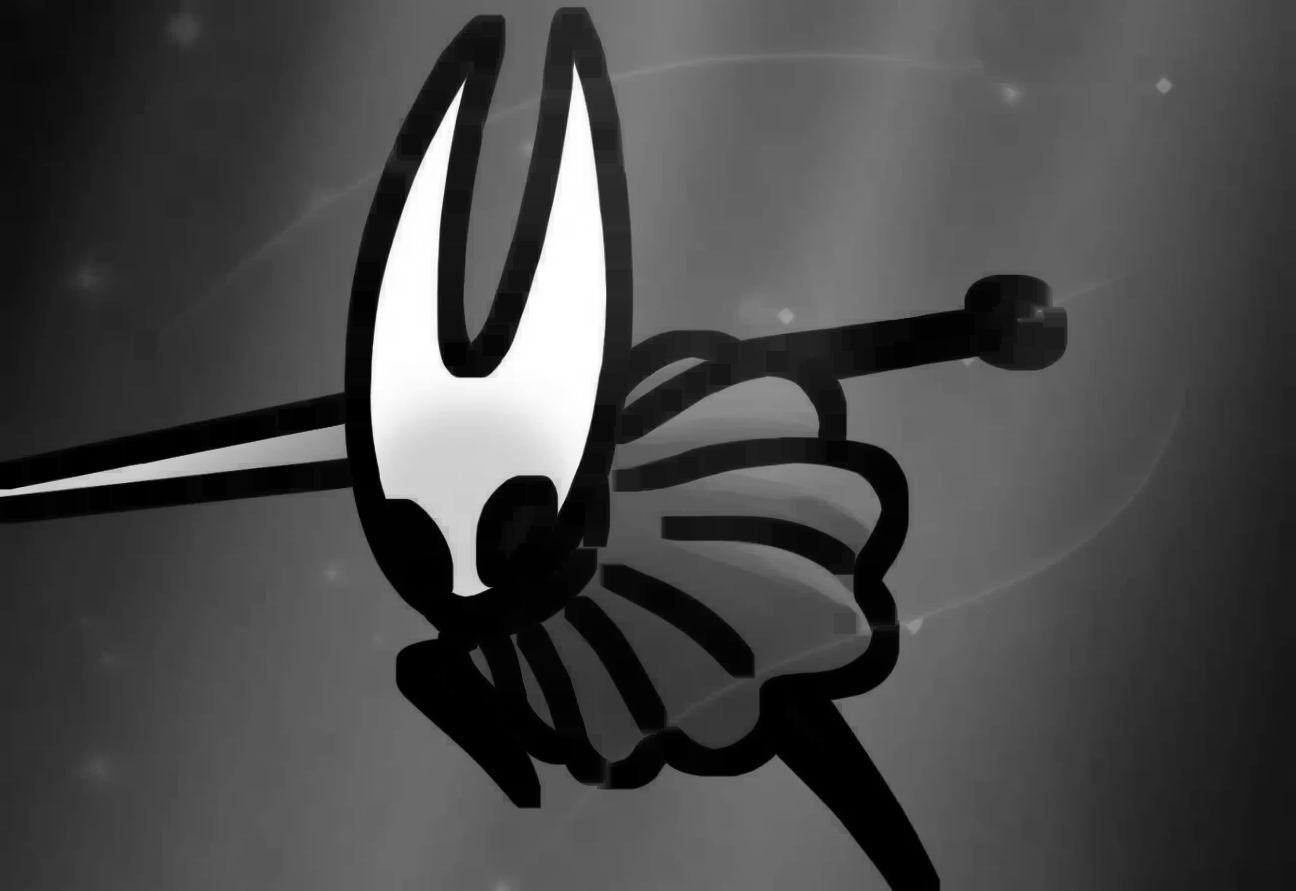

In [276]:
Image.fromarray(img_gray_ero)

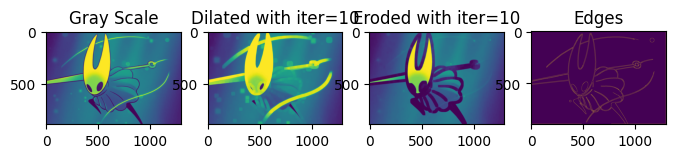

In [277]:
fig, axes = plt.subplots(1,4,figsize=(8,4))

axes[0].imshow(img_gray)
axes[0].set_title('Gray Scale')

axes[1].imshow(img_gray_dil)
axes[1].set_title(f'Dilated with iter={num_iter}')

axes[2].imshow(img_gray_ero)
axes[2].set_title(f'Eroded with iter={num_iter}')

axes[3].imshow(edges * 255)
axes[3].set_title(f'Edges')


plt.show()

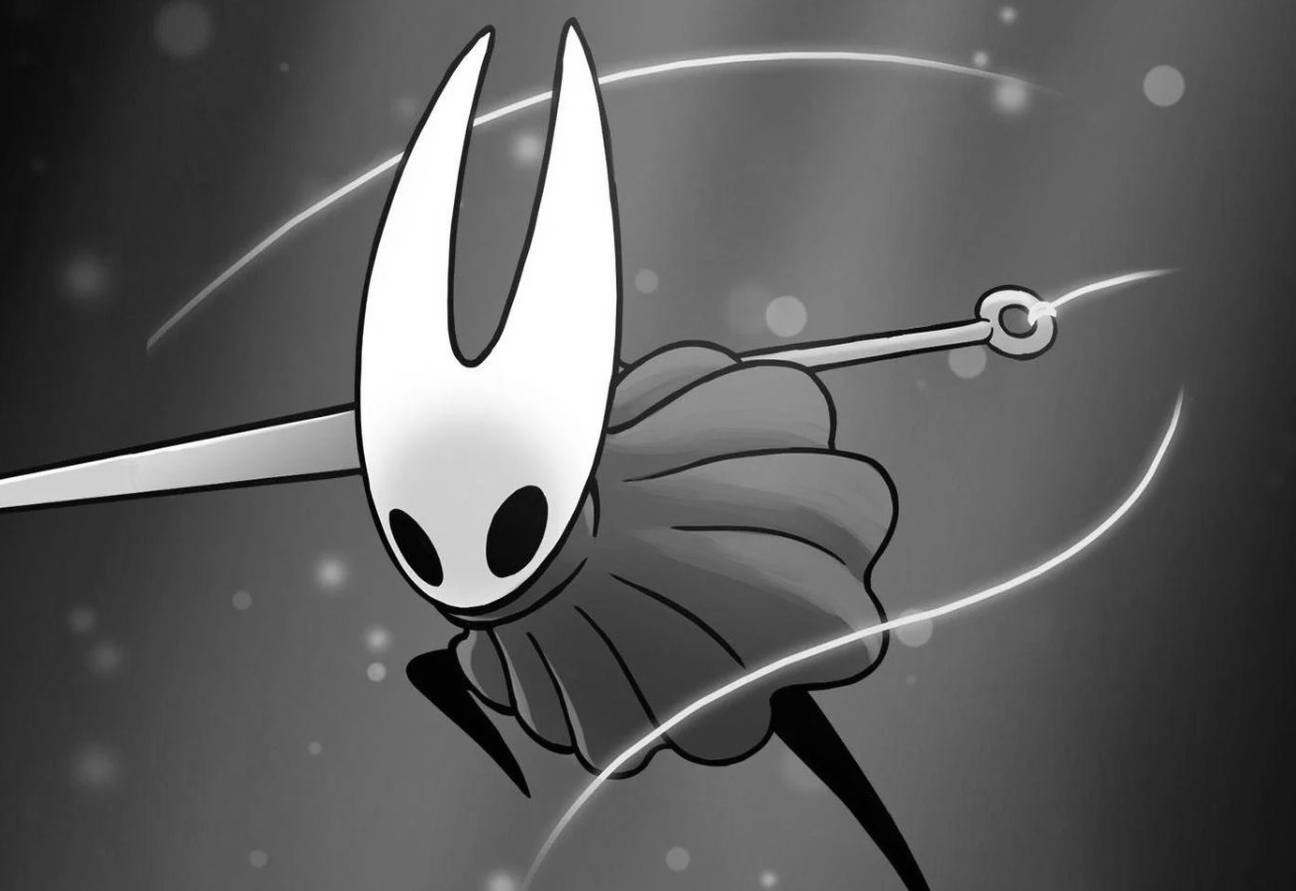

In [278]:
Image.fromarray(img_gray)

In [279]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(448, 640), dtype=uint8)

In [280]:
edges

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0, 255, ..., 255,   0,   0],
       ...,
       [  0,   0, 255, ..., 255,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], shape=(895, 1300), dtype=uint8)

In [281]:
mask_bin = (mask > 0).astype('uint8') * 255

In [282]:
edges_bin = (edges > 0).astype('uint8') * 255

In [283]:
h, w = edges_bin.shape

In [284]:
mask_resize = cv2.resize(mask_bin, (w, h), interpolation=cv2.INTER_NEAREST)

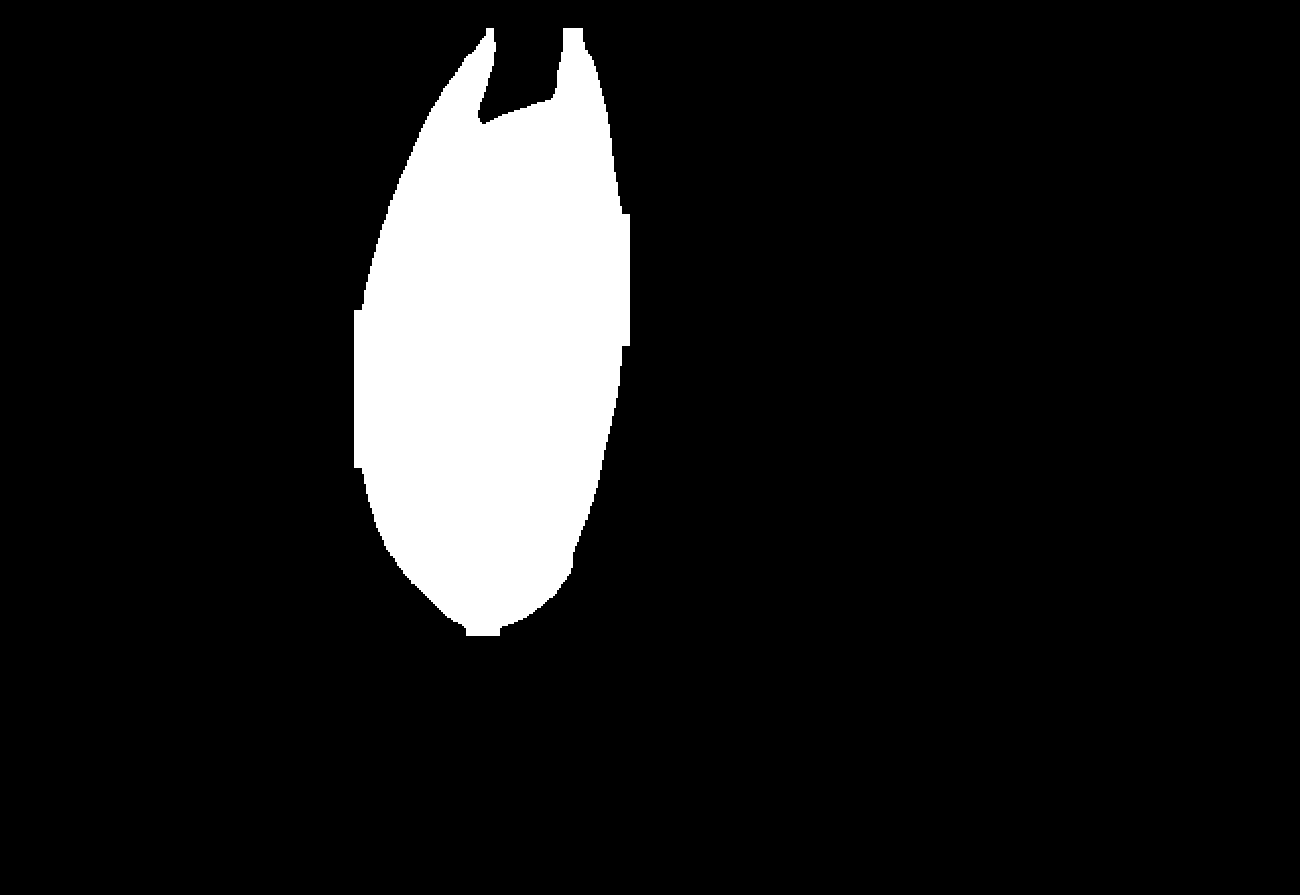

In [285]:
Image.fromarray(mask_resize)

In [286]:
mask_or = cv2.bitwise_or(mask_resize, edges_bin)

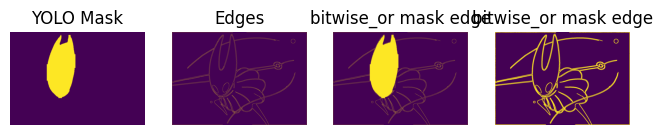

In [287]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
mask_dil = cv2.dilate(edges_bin, kernel, iterations= 1)

fig, axes = plt.subplots(1,4, figsize=(8,4))

axes[0].imshow(mask_resize)
axes[0].set_title('YOLO Mask')

axes[1].imshow(edges_bin)
axes[1].set_title(f'Edges')

axes[2].imshow(mask_or)
axes[2].set_title(f'bitwise_or mask edge')

axes[3].imshow(mask_dil)
axes[3].set_title(f'bitwise_or mask edge')

for ax in axes:
    ax.axis('OFF')

plt.show()

In [288]:
# edges_bin_ero = cv2.dilate(edges_bin, kernel, iterations= 2)

In [289]:
closed = cv2.morphologyEx(edges_bin, cv2.MORPH_CLOSE, kernel, iterations= 1)

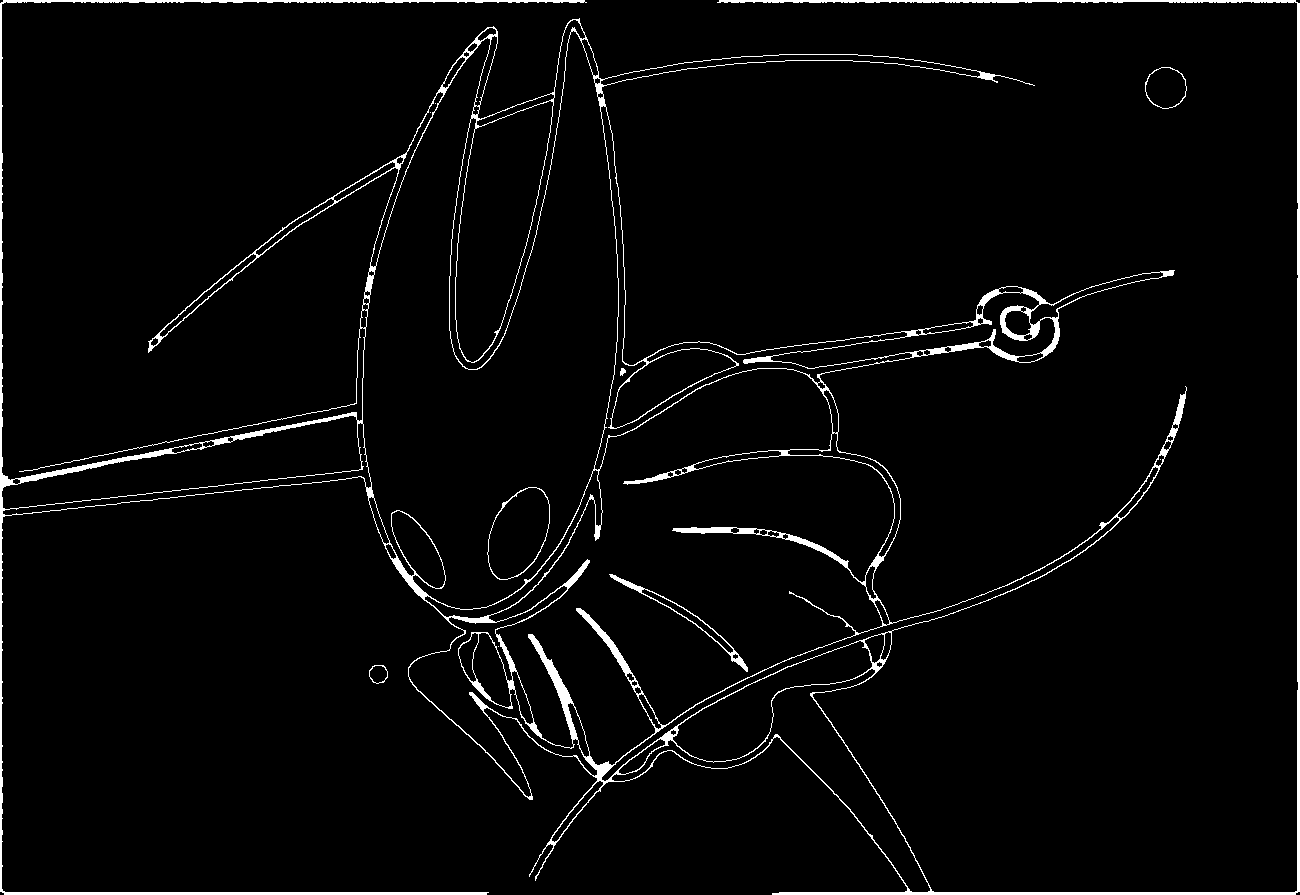

In [290]:
Image.fromarray(closed)

In [291]:
contoures, _ = cv2.findContours(
    closed,
    cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE
)

In [292]:
mask_c = np.zeros(padded_gray.shape, dtype=np.uint8)

In [293]:
cv2.drawContours(mask_c, contoures, -1 , 255, thickness= cv2.FILLED)

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0, 255, 255, ..., 255,   0,   0],
       ...,
       [  0,   0, 255, ..., 255,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], shape=(895, 1300), dtype=uint8)

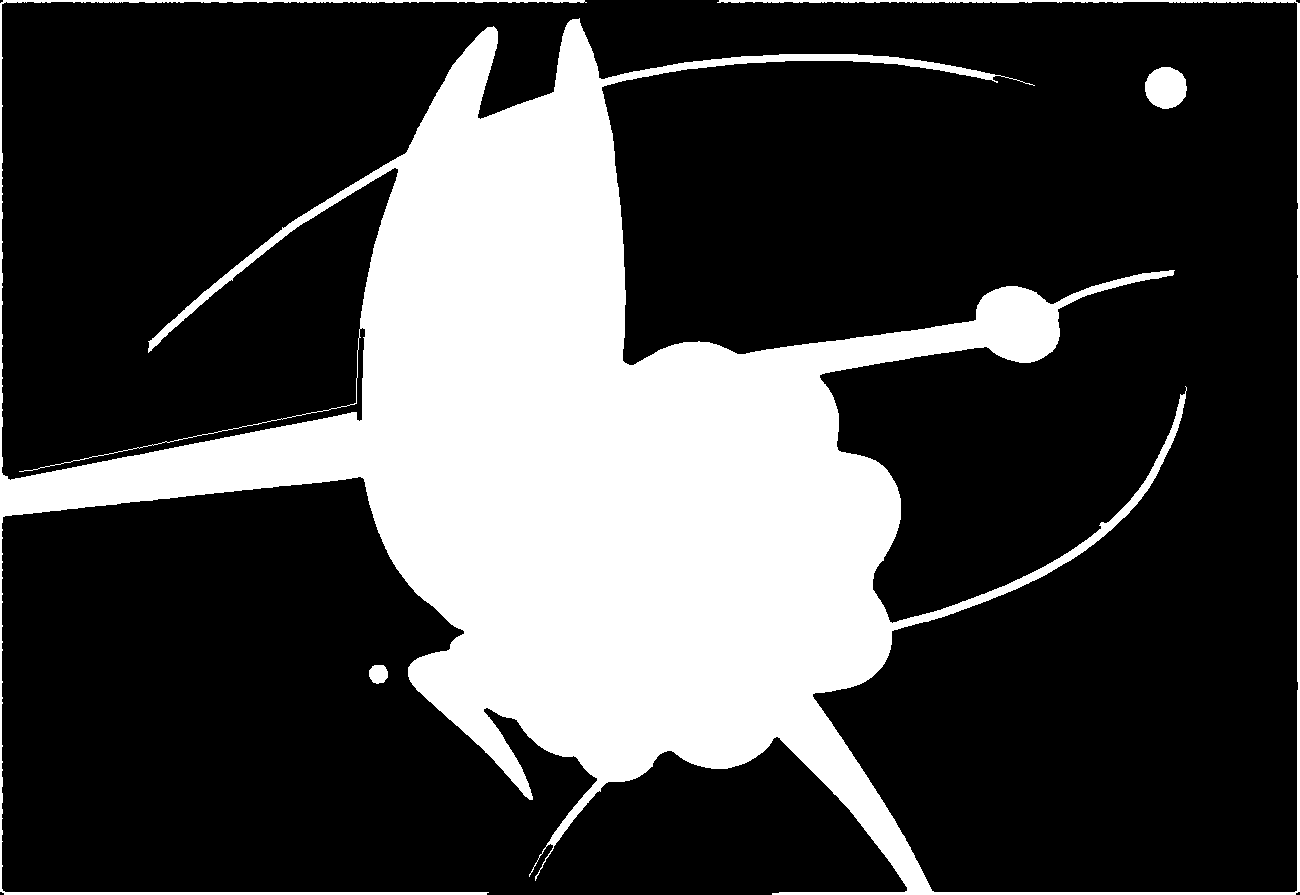

In [294]:
Image.fromarray(mask_c)

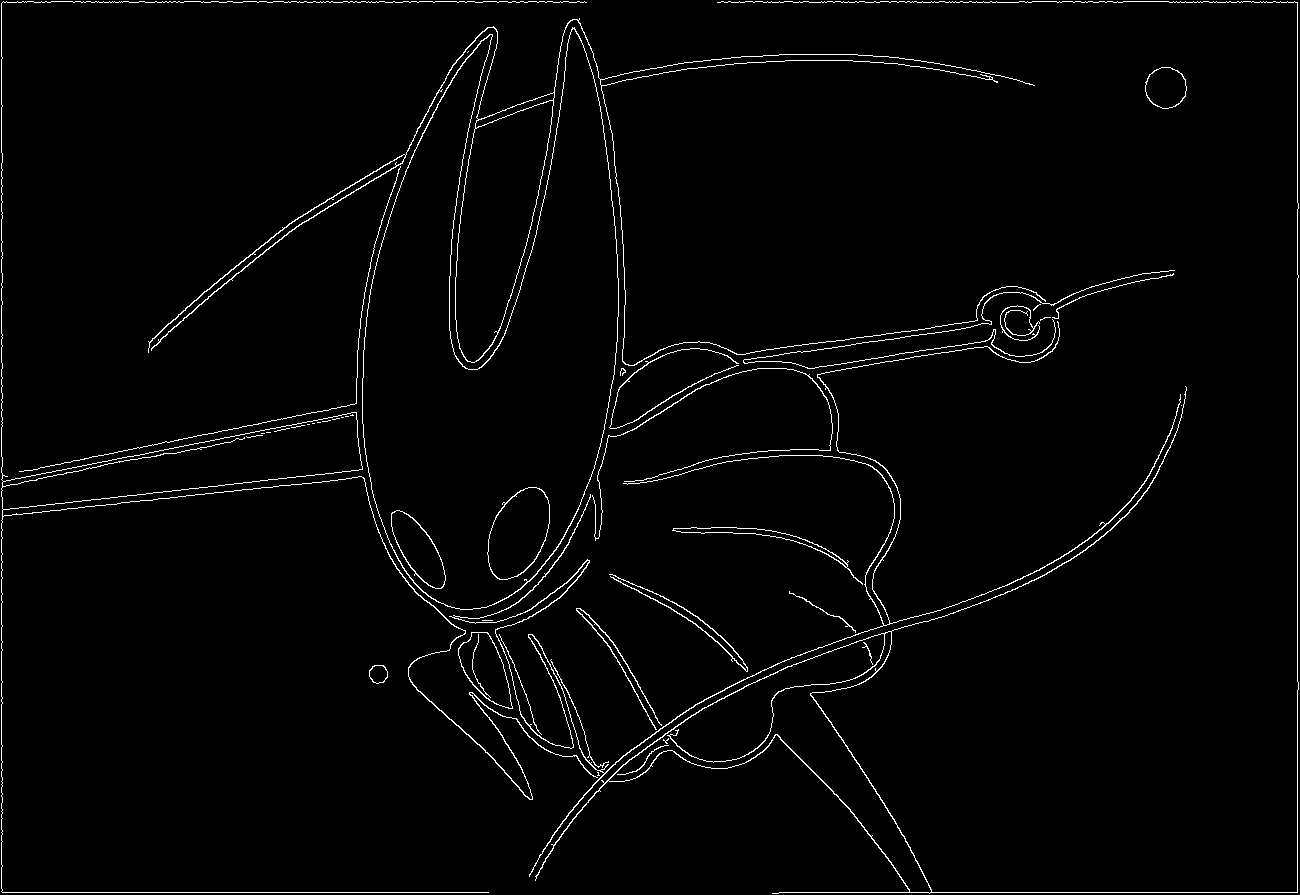

In [295]:
Image.fromarray(edges)

In [296]:
edges.shape

(895, 1300)

In [297]:
padded_gray.shape

(895, 1300)

In [298]:
h, w = img_gray.shape

In [299]:
mask_c_resize = cv2.resize(mask_c, (w, h))

In [300]:
segmented = cv2.bitwise_and(img_gray, mask_c_resize)

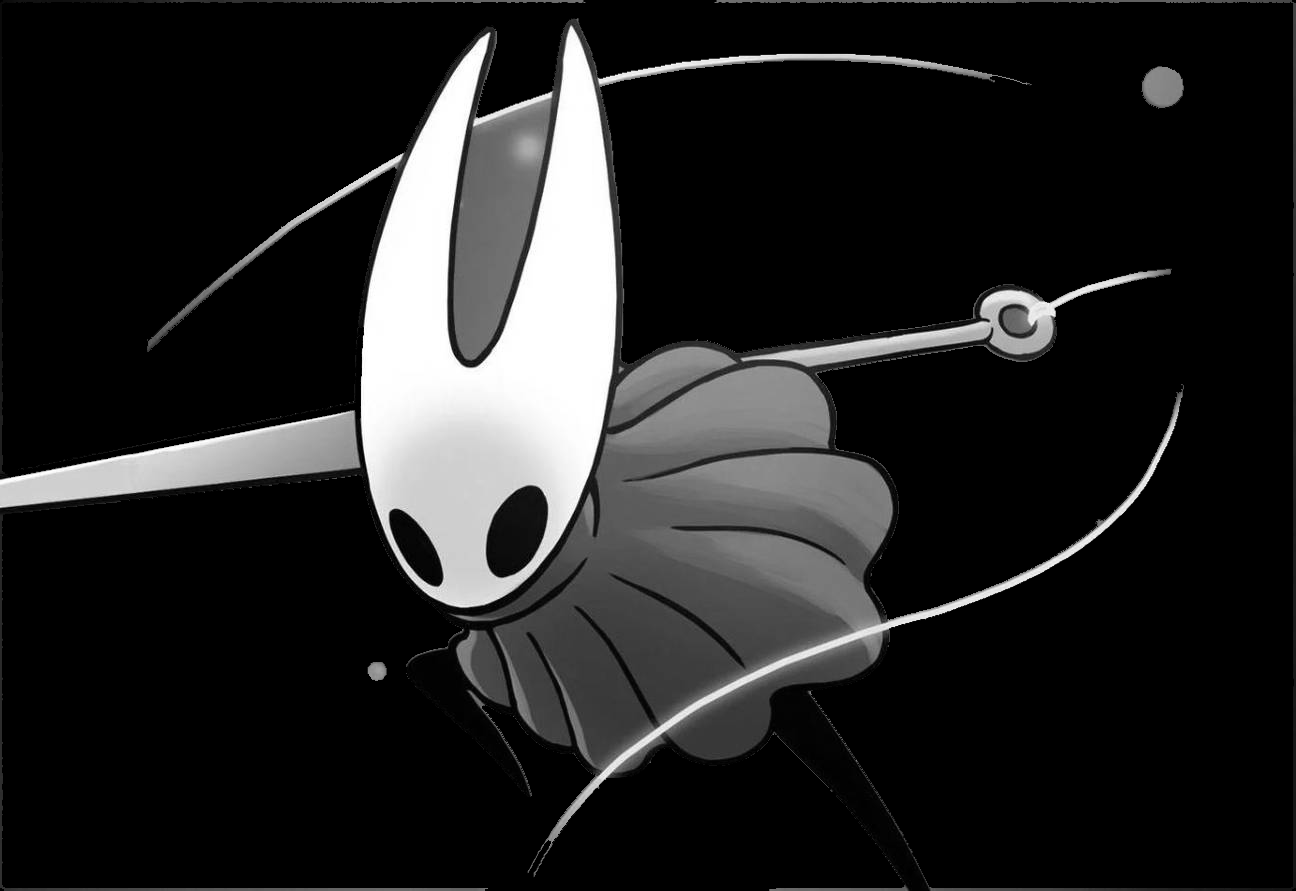

In [301]:
Image.fromarray(segmented)

In [304]:
# norm = cv2.normalize(
#     img_gray,
#     None,
#     alpha= 0,
#     beta= 255,
#     norm_type= cv2.NORM_MINMAX
# )

In [390]:
chars = """$@B%8&WM#*oahkbdpqwmZO0QLCJUYXzcvunxrjft/|()1{}[]?-_+~<>i!lI;:,"^`'. """[::-1]
char_len = len(chars)
chars_np = np.array(list(chars))

In [391]:
chars_np

array([' ', '.', "'", '`', '^', '"', ',', ':', ';', 'I', 'l', '!', 'i', '>', '<', '~', '+', '_', '-', '?', ']', '[', '}', '{', '1', ')', '(', '|', '/', 't', 'f', 'j', 'r', 'x', 'n', 'u', 'v', 'c', 'z', 'X', 'Y', 'U', 'J', 'C', 'L', 'Q', '0', 'O', 'Z', 'm', 'w', 'q', 'p', 'd', 'b', 'k', 'h', 'a', 'o', '*', '#', 'M',
       'W', '&', '8', '%', 'B', '@', '$'], dtype='<U1')

In [458]:
factor = 16
new_h, new_w = h//factor, w//factor

In [459]:
scaled_seg = cv2.resize(segmented, (new_w, new_h))

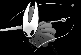

In [460]:
Image.fromarray(scaled_seg)

In [461]:
threshold = 0

In [462]:
def get_ascii(x):
    return np.floor((x.astype(float) * (char_len - 1)) / 255).astype(np.uint8)
    # return np.floor((x - threshold - 1) / (np.ceil((255 - threshold) / char_len)) - 1).astype(int)

In [463]:
img_ascii = np.where(True,chars_np[get_ascii(scaled_seg)],np.str_(' '))

In [464]:
lines = []
for line in img_ascii:
    line_list = list(line)
    line_list.append(np.str_('\n'))
    # print(line_list)
    new_line = ''.join(line)
    lines.append(new_line)

In [468]:
with open ('text_cv.txt', 'w', encoding='utf-8') as f:
    for line in lines:
        f.write(line)
        f.write('\n')

In [469]:
img_ascii

array([[' ', ' ', ' ', ..., ' ', ' ', ' '],
       [' ', ' ', ' ', ..., ' ', ' ', ' '],
       [' ', ' ', ' ', ..., ' ', ' ', ' '],
       ...,
       [' ', ' ', ' ', ..., ' ', ' ', ' '],
       [' ', ' ', ' ', ..., ' ', ' ', ' '],
       [' ', ' ', ' ', ..., ' ', ' ', ' ']], shape=(55, 81), dtype='<U1')

In [470]:
lines

['                                                                                 ',
 '                                   <                                             ',
 "                             'Z    %<                                            ",
 '                             @l    @B        ^M#oahhkkk1                         ',
 '                            B@+    @@  Wo}                 "v_          vn       ',
 '                           I@B    `@@<                                 jvu       ',
 '                           @$x  #c-@@~                                  j        ',
 '                          ;$$~zrffi$$a                                           ',
 '                          @@@||/cz~@$B                                           ',
 '                         !@$@(|tYJ8@$@                                           ',
 '                       * B@$B(|/jx@$$@                                           ',
 '                      x :@@$w|//tt@$$@+             

In [ ]:
cv2.imre